# **E-Commerce Analysis: Customer Churn & Delivery Problems**
An analysis of Brazillian E-Commerce transactions made at [Olist Store](www.olist.com).

**Created By:** *Fritz Immanuel & Gerard Louis Howan* (JCDS 2502)

## **> Introduction**

<hr>

[Olist](www.olist.com) is a Brazilian-based technology company that provides a platform to help small and medium-sized businesses sell their products on major online marketplaces. Founded in 2015, Olist acts as a bridge between merchants and e-commerce platforms like Amazon, Mercado Libre, and Magalu, enabling sellers to manage their inventory, listings, and orders from a single interface.

By offering logistics, catalog optimization, and customer service tools, Olist simplifies the process of selling online for retailers who might otherwise struggle with the complexity of marketplace requirements. Its goal is to democratize access to e-commerce and boost the visibility of smaller sellers in competitive digital environments.

### **Context**

Olist noticed something isn't right and decided to hire us, a team of Data Scientists, to take a deeper look. By giving us this dataset, we are tasked to look for problems with their business. So we decided to take a look at how their customers are doing and if theres anything wrong that we can improve. Most certainly, it is about customer churning. As we all know, an E-commerce platform is nothing without its customers. For this analysis, we will determine that any **customer who has not made any second order within 6 months** as a **churned customer**.

**Target:**<br>
0 => Staying Customer / non-churn<br>
1 => Leaving Customer / Churn<br>

### **Problem Statement**

With the growth of e-commerce, competition has become tougher than ever. There are so many online stores today, and customers can easily find one that fits their needs. This, however, isn’t great news for the platforms that aren’t as popular. To stay ahead, companies have to work hard to provide the best experience and attract more customers.

One way to do this is through big marketing campaigns. While these campaigns can be very expensive, they don’t always give the best results. In fact, companies often spend a lot of money without seeing a clear return. Instead of spending so much on uncertain results, it might make more sense to focus on **keeping** the customers they already have. Why? Because keeping existing customers is often easier than finding new ones. Offering things like discount vouchers or paying attention to customer complaints can help keep customers loyal and encourage them to return.

### **Goals**

To improve customer retention and reduce revenue loss, the company wants to build a model that can **accurately predict which customers are likely to churn**. This capability will allow the business to allocate retention resources more effectively—targeting at-risk customers with tailored offers and interventions. Beyond prediction, the company is also focused on understanding the **underlying reasons behind churn**, so it can improve the overall customer experience and make data-driven enhancements to its platform.

**Our goal is to answer the following key questions:**

* How do delivery problems—such as late shipments or inconsistent delivery times—affect customer churn?
* Are there geolocation patterns (e.g., by city, state, or zip code) associated with poor delivery experiences and higher churn rates?
* What customer or product-level attributes are most strongly correlated with an increased risk of churn?

By answering these questions, the company can take both **proactive and strategic actions** to improve service quality and customer satisfaction.


### **Analytic Approach**

We will be analyzing data to look for patterns, in which may help us determine the factors of customers churning. We will then build a classification machine learning model to help us and the company to determine which customers are more likely to churn/leave.

### **Metric Evaluation**

![Confusion Matrix](./images/Confusion%20Matrix.png)

There are 2 kinds of errors, **False Positive** & **False Negative**, in which has their own drawbacks.

#### **False Positive (FP)**<br>
The company spends resources on customers who are staying (not churning) because the model incorrectly predicts that they are leaving (churning).

#### **False Negative (FN)**<br>
The company loses a customer who actually churns, but the model fails to identify them as at risk, so little-to-no retention efforts are made.

#### **Cost Assumptions**<br>
To actually understand the scope of financial losses for each type of error we will assume some potential costs. For **False Positives**, on most cases companies will be prioritizing potential churners. This means the company will be spending more resources in order to retain these customers by giving them more benefits such as discount vouchers, etc.. We will assume that the company will be spending **R$150/customer/month**.

For **False Negatives**, the cost is typically higher because the company fails to act, resulting in the actual loss of a customer. For an e-commerce company like Olist, which operates a marketplace model supporting small and medium businesses, the value of a single active seller or buyer can be significant. With an approximate average of R$800/customer/month in gross revenue, the company probably takes about 15-20% as net revenue. To that, we will assume that the estimated loss will be **R$150/customer/month**

#### **Evaluation Metric**<br>
Although both **False Positives** and **False Negatives** are estimated at R\$150 per customer per month, the nature of these costs is fundamentally different: **False Positive costs are potential and often inflated**, as not all flagged customers will fully utilize retention offers like discounts or perks, meaning the actual expense may be lower than estimated. On the other hand, **False Negatives represent a concrete and irreversible loss**, since a churned customer directly translates into lost revenue and potential long-term value. Because of this asymmetry in risk and impact, relying solely on accuracy or other unbalanced metrics can be misleading. A more suitable evaluation metric in this context is the **F1 Score**, which balances precision and recall to ensure the model effectively identifies true churners while minimizing unnecessary retention efforts.


## **> Data Understanding & Cleaning**
<hr>

### **Context**

Dataset source: [Kaggle - Brazilian E-Commerce](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce)


- Dataset is **imbalanced**
- Dataset contains **high-cardinality categorical features**
- 

### **Import Libraries**

In [83]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import folium

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None) # display all columns, without limits
pd.set_option('display.max_colwidth', None)

### **Load Datasets**

In [84]:
# load dataset
customers_df = pd.read_csv('dataset/raw/olist_customers_dataset.csv')

orders_df = pd.read_csv('dataset/raw/olist_orders_dataset.csv')
order_items_df = pd.read_csv('dataset/raw/olist_order_items_dataset.csv')
order_payments_df = pd.read_csv('dataset/raw/olist_order_payments_dataset.csv')
order_reviews_df = pd.read_csv('dataset/raw/olist_order_reviews_dataset.csv')

products_df = pd.read_csv('dataset/raw/olist_products_dataset.csv')
pcateg_translation_df = pd.read_csv('dataset/raw/product_category_name_translation.csv')

sellers_df = pd.read_csv('dataset/raw/olist_sellers_dataset.csv')

geolocation_df = pd.read_csv('dataset/raw/olist_geolocation_dataset.csv')

### **Function Library**

In [85]:
def pltFigsize(size: tuple):
  plt.figure(figsize=size)

In [86]:
def pltTitle(title: str):
  plt.title(
    title,
    fontdict={
      'fontsize': 16,
      'fontweight' : 'bold',
    }
  )

In [87]:
def showBoxPlot(source, col_x: str, x_axis_label: str):
  sns.boxplot(source, x=col_x)

  pltTitle(f"Distribution of {x_axis_label}")

  plt.xlabel(x_axis_label)

In [88]:
def showHistplot(source, col_x: str, x_axis_label: str):
  sns.histplot(source, x=col_x, kde=True)

  pltTitle(f"Frequency Distribution of {x_axis_label}")

  plt.xlabel(x_axis_label)

In [89]:
def showDistributionCombo(source, col_x: str, x_axis_label: str):
  plt.figure(figsize=(20,5))

  plt.subplot(1,2,1)
  showBoxPlot(source,  col_x, x_axis_label)

  plt.subplot(1,2,2)
  showHistplot(source,  col_x, x_axis_label)

  plt.show()

In [90]:
def showUniqueValues(source, limit: int):
	listItem = []
	for col in source.columns :
		listItem.append([col, source[col].nunique(), source[col].sort_values().unique()])

	df_uniques_per_column = pd.DataFrame(columns=['Column Name', 'Number of Unique', 'Unique Sample'], data=listItem)

	if limit > 0:
		return df_uniques_per_column[df_uniques_per_column['Number of Unique']<=limit].sort_values('Number of Unique', ascending=False)
	else:
		return df_uniques_per_column.sort_values('Number of Unique', ascending=False)

### **Customers Dataset**

some descriptive text here

**`olist_customers_dataset.csv` (99,441 rows)**

| Column Name                | Data Type | Description                                                 |
| -------------------------- | --------- | ----------------------------------------------------------- |
| `customer_id`              | `object`/`string`  | Unique identifier for each customer.                        |
| `customer_unique_id`       | `object`/`string`  | Unique identifier for each customer across multiple orders. |
| `customer_zip_code_prefix` | `int64`   | First five digits of the customer's zip code.               |
| `customer_city`            | `object`/`string`  | City where the customer is located.                         |
| `customer_state`           | `object`/`string`  | State where the customer is located.                        |

#### **Unique Values**

In [91]:
showUniqueValues(customers_df, 14994) # add limit to remove '_id's from the list, as it is not important here

,Column Name,Number of Unique,Unique Sample
2,customer_zip_code_prefix,14994,"[1003, 1004, 1005, 1006, 1007, 1008, 1009, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1030, 1031, 1032, 1033, 1035, 1036, 1037, 1038, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1102, 1103, 1105, 1106, 1107, 1108, 1120, 1121, 1122, 1123, 1124, 1125, 1127, 1129, 1131, 1132, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1144, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209, 1210, 1211, 1213, 1214, 1215, 1216, 1217, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, ...]"
3,customer_city,4119,"[abadia dos dourados, abadiania, abaete, abaetetuba, abaiara, abaira, abare, abatia, abdon batista, abelardo luz, abrantes, abre campo, abreu e lima, acaiaca, acailandia, acajutiba, acarau, acari, acegua, acopiara, acreuna, acu, acucena, adamantina, adhemar de barros, adolfo, adrianopolis, adustina, afogados da ingazeira, afonso claudio, afranio, agisse, agrestina, agrolandia, agronomica, agua boa, agua branca, agua clara, agua comprida, agua doce, agua doce do norte, agua fria de goias, agua limpa, agua nova, agua preta, agua santa, aguai, aguas belas, aguas claras, aguas da prata, aguas de lindoia, aguas de santa barbara, aguas de sao pedro, aguas formosas, aguas frias, aguas lindas de goias, aguas mornas, aguas vermelhas, agudo, agudos, aguia branca, aimores, aiuaba, aiuruoca, ajapi, ajuricaba, alagoa, alagoa grande, alagoa nova, alagoinha, alagoinhas, alambari, alcantara, alcinopolis, alcobaca, alegre, alegrete, alegrete do piaui, alegria, alem paraiba, alexandra, alexandria, alexandrita, alexania, alfenas, alfredo chaves, alfredo marcondes, alfredo vasconcelos, alfredo wagner, alhandra, alianca, alianca do tocantins, almas, almenara, almino afonso, almirante tamandare, almirante tamandare do sul, alpercata, alpestre, alpinopolis, ...]"
4,customer_state,27,"[AC, AL, AM, AP, BA, CE, DF, ES, GO, MA, MG, MS, MT, PA, PB, PE, PI, PR, RJ, RN, RO, RR, RS, SC, SE, SP, TO]"


#### **Missing Values**

In [92]:
customers_df.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

No missing value / NaNs needed to be handled.

#### **Standardize Text-Case**

In [93]:
customers_df['customer_city'] = customers_df['customer_city'].str.lower()

#### **Duplicates**

In [94]:
customers_df.duplicated().sum()

0

No duplicates found, no action needed.

### **Orders Dataset**

some desc text here

**`olist_orders_dataset.csv` (99,441 rows)**

| Column Name                     | Data Type        | Description                                                       |
| ------------------------------- | ---------------- | ----------------------------------------------------------------- |
| `order_id`                      | `object`/`string`         | Unique identifier for each order.                                 |
| `customer_id`                   | `object`/`string`         | Unique identifier for the customer who placed the order.          |
| `order_status`                  | `object`/`string`         | Current status of the order (e.g., delivered, shipped, canceled). |
| `order_purchase_timestamp`      | `object`/`string` | Timestamp when the order was placed.                              |
| `order_approved_at`             | `object`/`string` | Timestamp when the order was approved.                            |
| `order_delivered_carrier_date`  | `object`/`string` | Timestamp when the order was handed over to the carrier.          |
| `order_delivered_customer_date` | `object`/`string` | Timestamp when the order was delivered to the customer.           |
| `order_estimated_delivery_date` | `object`/`string` | Estimated delivery date for the order.                            |

#### **Unique Values**

In [95]:
showUniqueValues(orders_df, 98875)

,Column Name,Number of Unique,Unique Sample
3,order_purchase_timestamp,98875,"[2016-09-04 21:15:19, 2016-09-05 00:15:34, 2016-09-13 15:24:19, 2016-09-15 12:16:38, 2016-10-02 22:07:52, 2016-10-03 09:44:50, 2016-10-03 16:56:50, 2016-10-03 21:01:41, 2016-10-03 21:13:36, 2016-10-03 22:06:03, 2016-10-03 22:31:31, 2016-10-03 22:44:10, 2016-10-03 22:51:30, 2016-10-04 09:06:10, 2016-10-04 09:16:33, 2016-10-04 09:59:03, 2016-10-04 10:05:45, 2016-10-04 10:16:04, 2016-10-04 10:41:17, 2016-10-04 11:03:14, 2016-10-04 11:44:01, 2016-10-04 12:06:11, 2016-10-04 12:53:17, 2016-10-04 13:02:10, 2016-10-04 13:11:29, 2016-10-04 13:15:46, 2016-10-04 13:15:52, 2016-10-04 13:16:57, 2016-10-04 13:22:56, 2016-10-04 13:30:13, 2016-10-04 13:38:37, 2016-10-04 13:40:43, 2016-10-04 13:45:08, 2016-10-04 14:13:22, 2016-10-04 14:23:50, 2016-10-04 14:44:33, 2016-10-04 14:49:13, 2016-10-04 14:51:15, 2016-10-04 15:02:37, 2016-10-04 15:02:53, 2016-10-04 15:07:21, 2016-10-04 15:10:15, 2016-10-04 15:12:18, 2016-10-04 15:35:35, 2016-10-04 15:44:44, 2016-10-04 16:02:18, 2016-10-04 16:05:29, 2016-10-04 16:08:52, 2016-10-04 16:28:25, 2016-10-04 16:40:07, 2016-10-04 16:41:59, 2016-10-04 17:08:39, 2016-10-04 17:25:09, 2016-10-04 18:02:37, 2016-10-04 18:07:24, 2016-10-04 18:52:56, 2016-10-04 19:01:13, 2016-10-04 19:25:29, 2016-10-04 19:30:28, 2016-10-04 19:41:32, 2016-10-04 19:41:52, 2016-10-04 20:41:45, 2016-10-04 20:41:55, 2016-10-04 21:25:32, 2016-10-04 21:32:35, 2016-10-04 21:35:54, 2016-10-04 21:54:52, 2016-10-04 22:03:46, 2016-10-04 22:15:11, 2016-10-04 22:33:44, 2016-10-04 22:43:33, 2016-10-04 23:08:08, 2016-10-04 23:26:51, 2016-10-04 23:39:01, 2016-10-04 23:45:54, 2016-10-04 23:59:01, 2016-10-05 00:32:31, 2016-10-05 01:47:40, 2016-10-05 07:31:49, 2016-10-05 08:01:47, 2016-10-05 08:04:21, 2016-10-05 08:41:18, 2016-10-05 08:46:55, 2016-10-05 09:19:46, 2016-10-05 09:46:43, 2016-10-05 11:01:40, 2016-10-05 11:05:52, 2016-10-05 11:08:46, 2016-10-05 11:23:13, 2016-10-05 11:44:41, 2016-10-05 11:54:15, 2016-10-05 12:32:55, 2016-10-05 12:34:04, 2016-10-05 12:41:38, 2016-10-05 12:44:09, 2016-10-05 13:12:43, 2016-10-05 13:22:20, 2016-10-05 14:16:28, 2016-10-05 14:36:55, 2016-10-05 14:40:44, ...]"
6,order_delivered_customer_date,95664,"[2016-10-11 13:46:32, 2016-10-11 14:46:49, 2016-10-13 03:10:34, 2016-10-13 07:45:48, 2016-10-13 15:44:27, 2016-10-13 15:44:57, 2016-10-13 15:45:44, 2016-10-13 15:49:48, 2016-10-13 15:56:11, 2016-10-13 15:56:28, 2016-10-13 16:00:43, 2016-10-13 16:03:06, 2016-10-13 16:03:33, 2016-10-13 16:03:46, 2016-10-13 16:51:46, 2016-10-13 19:31:39, 2016-10-14 02:49:22, 2016-10-14 03:10:07, 2016-10-14 08:29:50, 2016-10-14 09:09:13, 2016-10-14 10:16:04, 2016-10-14 11:03:10, 2016-10-14 12:13:52, 2016-10-14 12:14:57, 2016-10-14 12:15:24, 2016-10-14 15:07:11, 2016-10-14 15:59:10, 2016-10-14 15:59:26, 2016-10-14 16:08:00, 2016-10-14 19:28:40, 2016-10-14 19:29:13, 2016-10-14 22:15:33, 2016-10-15 01:01:29, 2016-10-15 03:51:25, 2016-10-15 04:17:21, 2016-10-15 05:02:06, 2016-10-15 05:02:16, 2016-10-15 11:00:25, 2016-10-15 11:02:24, 2016-10-15 13:19:54, 2016-10-15 13:22:13, 2016-10-15 13:42:50, 2016-10-15 15:09:06, 2016-10-15 16:34:44, 2016-10-15 18:32:03, 2016-10-15 18:34:07, 2016-10-15 18:54:23, 2016-10-15 20:38:26, 2016-10-15 22:02:14, 2016-10-16 10:41:50, 2016-10-16 14:36:00, 2016-10-16 14:36:59, 2016-10-16 14:57:02, 2016-10-16 15:35:21, 2016-10-16 15:55:15, 2016-10-16 16:57:14, 2016-10-16 17:51:52, 2016-10-17 02:55:39, 2016-10-17 11:25:59, 2016-10-17 12:03:07, 2016-10-17 12:03:19, 2016-10-17 12:03:34, 2016-10-17 12:03:38, 2016-10-17 13:02:12, 2016-10-17 13:02:21, 2016-10-17 13:02:46, 2016-10-17 14:01:34, 2016-10-17 15:36:53, 2016-10-17 15:42:00, 2016-10-17 16:47:46, 2016-10-17 17:43:18, 2016-10-17 17:43:19, 2016-10-17 18:39:46, 2016-10-17 19:08:17, 2016-10-17 19:29:03, 2016-10-17 19:31:23, 2016-10-17 19:41:12, 2016-10-17 20:24:25, 2016-10-18 01:37:54, 2016-10-18 05:56:37, 2016-10-18 06:02:45, 2016-10-18 06:03:07, 2016-10-18 09:57:48, 2016-10-18 13:24:17, 2016-10-18 

#### **Handle Column Type**

In [96]:
orders_df['order_purchase_timestamp'] = pd.to_datetime(orders_df['order_purchase_timestamp'])
orders_df['order_approved_at'] = pd.to_datetime(orders_df['order_approved_at'])
orders_df['order_delivered_carrier_date'] = pd.to_datetime(orders_df['order_delivered_carrier_date'])
orders_df['order_delivered_customer_date'] = pd.to_datetime(orders_df['order_delivered_customer_date'])
orders_df['order_estimated_delivery_date'] = pd.to_datetime(orders_df['order_estimated_delivery_date'])

#### **Missing Values**

In [97]:
orders_df.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

We can see that there are some missing values on 3 columns. The columns in question happens to be related to the status of the order, thus we cant blindy remove them. For this we will check for patterns.

In [98]:
missing_pattern_by_status = orders_df.groupby('order_status').apply(
		lambda x: x[['order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date']].isna().astype(int)
		.groupby(list(x[['order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date']].columns)).size()
	).reset_index(name='count')
missing_pattern_by_status

,order_status,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,count
0,approved,0,1,1,2
1,canceled,0,0,0,6
2,canceled,0,0,1,69
3,canceled,0,1,1,409
4,canceled,1,1,1,141
5,created,1,1,1,5
6,delivered,0,0,0,96455
7,delivered,0,0,1,7
8,delivered,0,1,0,1
9,delivered,0,1,1,1


After reviewing the data and identifying inconsistencies, we decided to remove rows with specific `order_status` and missing values patterns that didn't align with expected e-commerce behavior. Specifically, we removed:

1. **Canceled orders** that had all delivery information present — this is inconsistent since a canceled order should not have delivery timestamps (`id 1`).
2. **Delivered orders** with missing or contradictory delivery timestamps — these rows are either incomplete or logically impossible (`id 7, 8, 9, 10`).
3. **Unavailable orders** that lacked delivery information — the status of "unavailable" should generally not have valid delivery data, making these rows unclear or incomplete (`id 14`).

In [99]:
orders_df = orders_df[~orders_df.apply(
  lambda row: (row['order_status'], pd.isna(row['order_approved_at']), pd.isna(row['order_delivered_carrier_date']), pd.isna(row['order_delivered_customer_date'])) in [
    ('canceled', False, False, False),   # id 1
    ('delivered', False, False, True),   # id 7
    ('delivered', False, True, False),   # id 8
    ('delivered', False, True, True),    # id 9
    ('delivered', True, False, False),   # id 10
    ('unavailable', False, True, True)   # id 14
], axis=1)]


In [100]:
orders_df

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26
...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15


#### **Duplicates**

In [101]:
orders_df.duplicated().sum()

0

No duplicates found, no action needed.

#### **Feature Engineering**

To help us analyze the data further, we will have to decompose datetime related

In [102]:
datetime_columns = [
	'order_purchase_timestamp', 'order_approved_at', 
	'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date'
]

for col in datetime_columns:
	orders_df[f'{col}_year'] = orders_df[col].dt.year
	orders_df[f'{col}_month'] = orders_df[col].dt.month
	orders_df[f'{col}_day'] = orders_df[col].dt.day
	orders_df[f'{col}_hour'] = orders_df[col].dt.hour
	orders_df[f'{col}_minute'] = orders_df[col].dt.minute
	orders_df[f'{col}_second'] = orders_df[col].dt.second

# Calculate the durations between different stages
orders_df['purchase_to_approval'] = (orders_df['order_approved_at'] - orders_df['order_purchase_timestamp']).dt.total_seconds()
orders_df['approval_to_carrier'] = (orders_df['order_delivered_carrier_date'] - orders_df['order_approved_at']).dt.total_seconds()
orders_df['carrier_to_customer'] = (orders_df['order_delivered_customer_date'] - orders_df['order_delivered_carrier_date']).dt.total_seconds()
orders_df['purchase_to_customer'] = (orders_df['order_delivered_customer_date'] - orders_df['order_purchase_timestamp']).dt.total_seconds()

In [103]:
orders_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_timestamp_year,order_purchase_timestamp_month,order_purchase_timestamp_day,order_purchase_timestamp_hour,order_purchase_timestamp_minute,order_purchase_timestamp_second,order_approved_at_year,order_approved_at_month,order_approved_at_day,order_approved_at_hour,order_approved_at_minute,order_approved_at_second,order_delivered_carrier_date_year,order_delivered_carrier_date_month,order_delivered_carrier_date_day,order_delivered_carrier_date_hour,order_delivered_carrier_date_minute,order_delivered_carrier_date_second,order_delivered_customer_date_year,order_delivered_customer_date_month,order_delivered_customer_date_day,order_delivered_customer_date_hour,order_delivered_customer_date_minute,order_delivered_customer_date_second,order_estimated_delivery_date_year,order_estimated_delivery_date_month,order_estimated_delivery_date_day,order_estimated_delivery_date_hour,order_estimated_delivery_date_minute,order_estimated_delivery_date_second,purchase_to_approval,approval_to_carrier,carrier_to_customer,purchase_to_customer
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017,10,2,10,56,33,2017.0,10.0,2.0,11.0,7.0,15.0,2017.0,10.0,4.0,19.0,55.0,0.0,2017.0,10.0,10.0,21.0,25.0,13.0,2017,10,18,0,0,0,642.0,204465.0,523813.0,728920.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018,7,24,20,41,37,2018.0,7.0,26.0,3.0,24.0,27.0,2018.0,7.0,26.0,14.0,31.0,0.0,2018.0,8.0,7.0,15.0,27.0,45.0,2018,8,13,0,0,0,110570.0,39993.0,1040205.0,1190768.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,2018,8,8,8,38,49,2018.0,8.0,8.0,8.0,55.0,23.0,2018.0,8.0,8.0,13.0,50.0,0.0,2018.0,8.0,17.0,18.0,6.0,29.0,2018,9,4,0,0,0,994.0,17677.0,792989.0,811660.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,2017,11,18,19,28,6,2017.0,11.0,18.0,19.0,45.0,59.0,2017.0,11.0,22.0,13.0,39.0,59.0,2017.0,12.0,2.0,0.0,28.0,42.0,2017,12,15,0,0,0,1073.0,323640.0,816523.0,1141236.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2018,2,13,21,18,39,2018.0,2.0,13.0,22.0,20.0,29.0,2018.0,2.0,14.0,19.0,46.0,34.0,2018.0,2.0,16.0,18.0,17.0,2.0,2018,2,26,0,0,0,3710.0,77165.0,167428.0,248303.0


#### **Unrealistic Values/Outliers**

In [104]:
# check order years
for col in datetime_columns:
	print(orders_df[f'{col}_year'].value_counts(), '\n')

order_purchase_timestamp_year
2018    53859
2017    44627
2016      317
Name: count, dtype: int64 

order_approved_at_year
2018.0    53834
2017.0    44512
2016.0      311
Name: count, dtype: int64 

order_delivered_carrier_date_year
2018.0    54042
2017.0    43313
2016.0      276
Name: count, dtype: int64 

order_delivered_customer_date_year
2018.0    55273
2017.0    40915
2016.0      267
Name: count, dtype: int64 

order_estimated_delivery_date_year
2018    58614
2017    39875
2016      314
Name: count, dtype: int64 



All order years seems to be aligning with the dataset scope, which is 2016-2018.

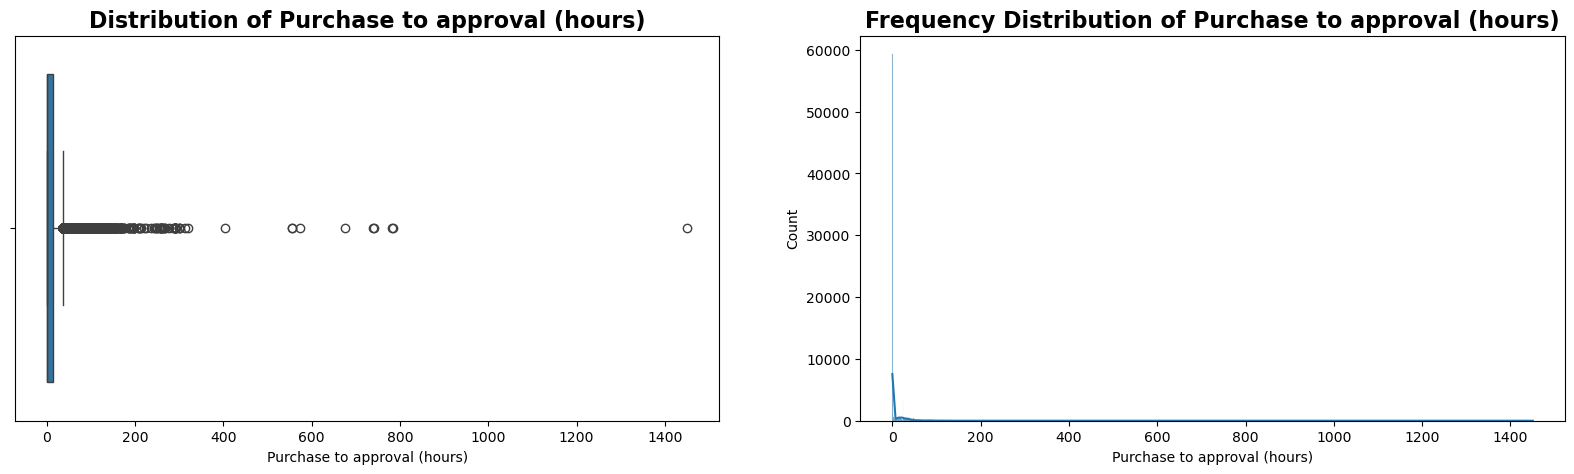

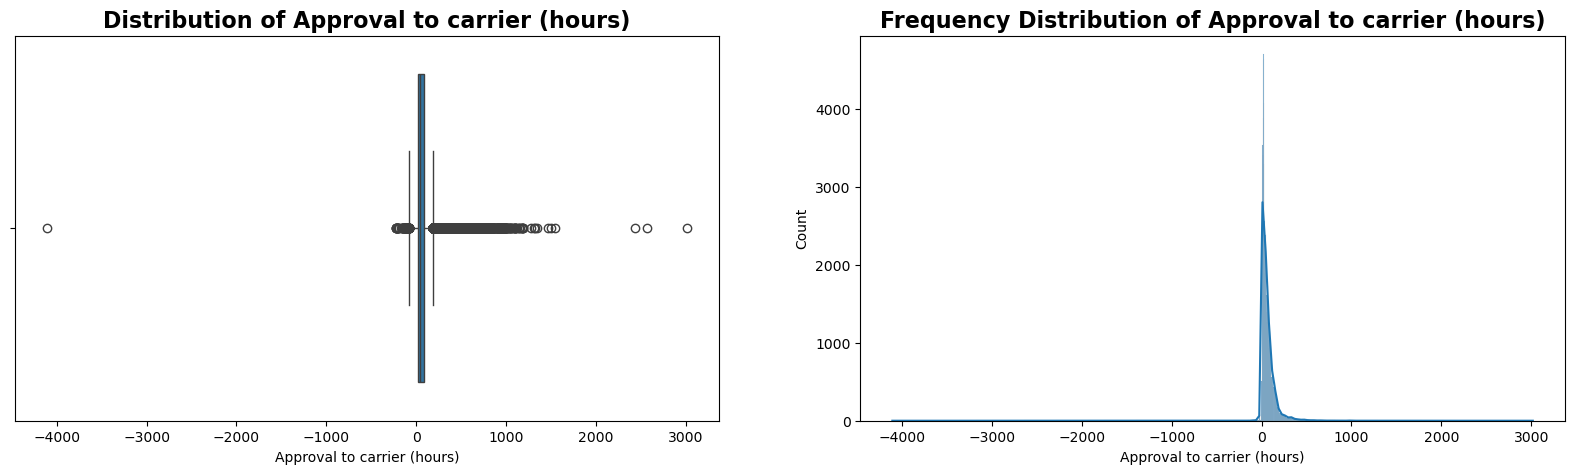

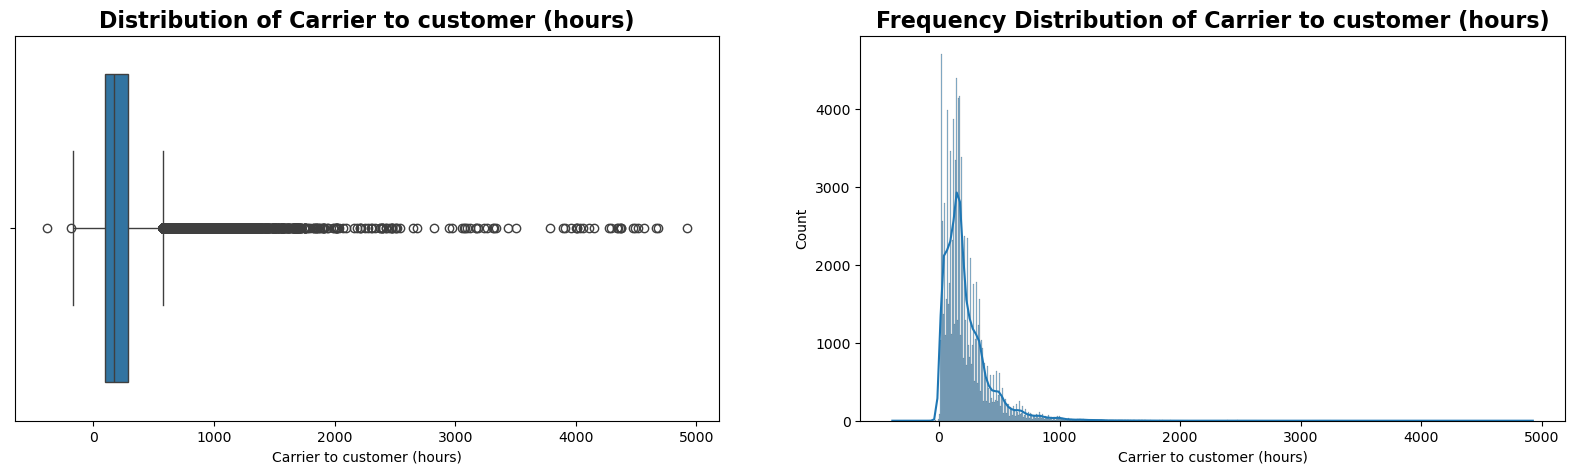

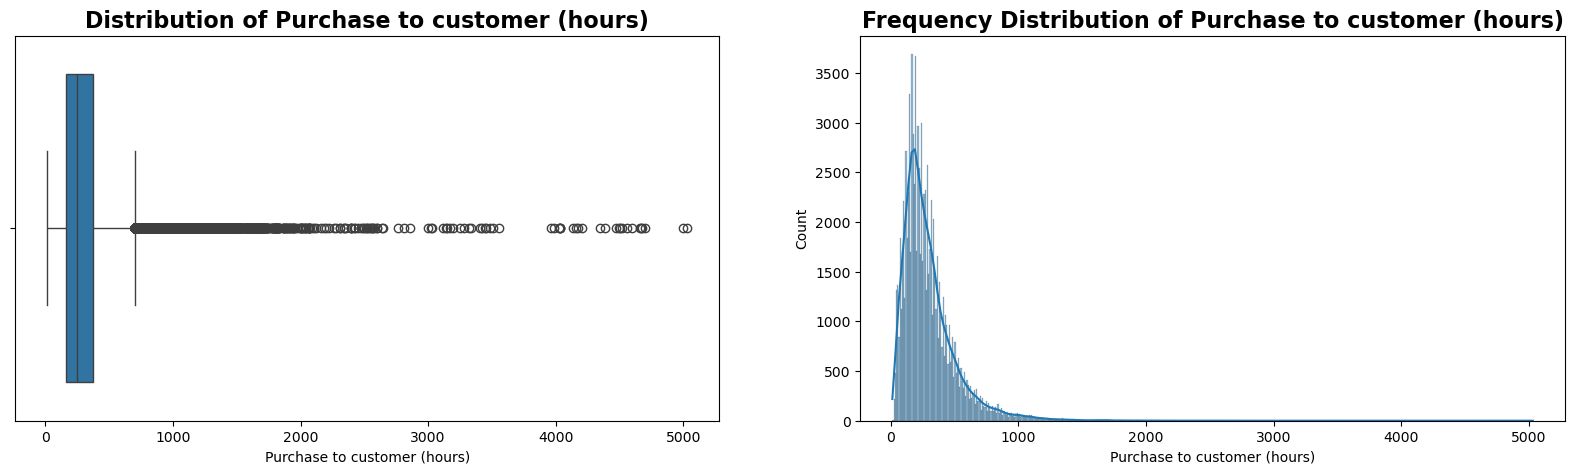

In [105]:
# check for durations data distribution
durations_cols =  ['purchase_to_approval', 'approval_to_carrier', 'carrier_to_customer', 'purchase_to_customer']

for dc in durations_cols:
  showDistributionCombo(orders_df.assign(temp=orders_df[dc] / 3600), 'temp', dc.replace('_', ' ', -1).capitalize() + ' (hours)')

Most orders follow a **tight and consistent delivery timeline**, as indicated by the sharp peaks near zero in all distributions—especially in the `purchase_to_approval` and `approval_to_carrier` durations. However, there are **significant long-tail outliers**, and in the case of `approval_to_carrier`, even **negative values**, which are logically invalid (a carrier date before approval doesn’t make sense). These likely stem from either data entry errors or system timestamp issues and should be carefully handled or removed.

In [106]:
# 1. Negative value removal
orders_df = orders_df[orders_df['approval_to_carrier']>=0]
orders_df = orders_df[orders_df['carrier_to_customer']>=0]

# 2. Outlier handling by limiting duration to <= 1 week
orders_df = orders_df[orders_df['purchase_to_approval'] <= 604800] # 1 week in seconds
orders_df = orders_df[orders_df['approval_to_carrier'] <= 604800]
orders_df = orders_df[orders_df['carrier_to_customer'] <= 604800]
# orders_df = orders_df[orders_df['purchase_to_customer'] <= ]

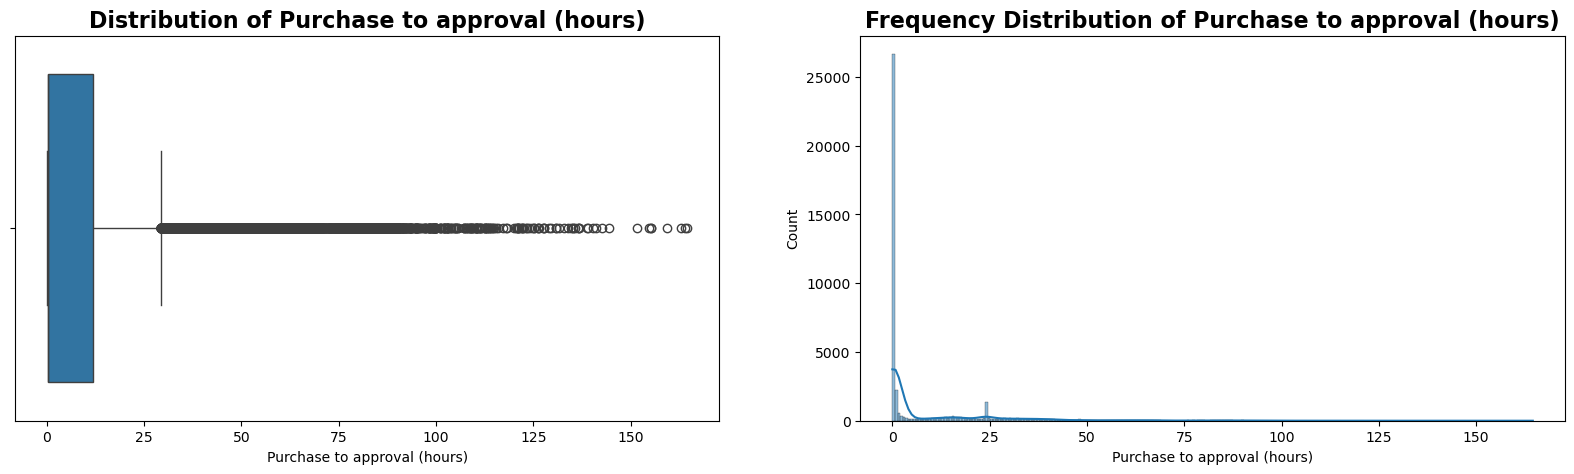

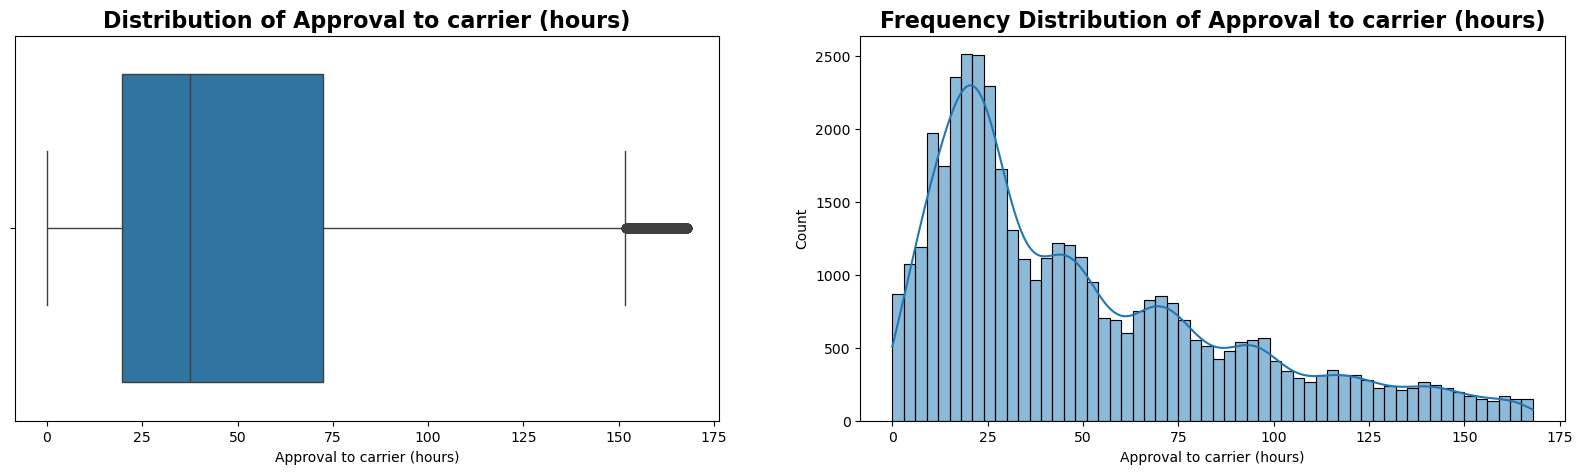

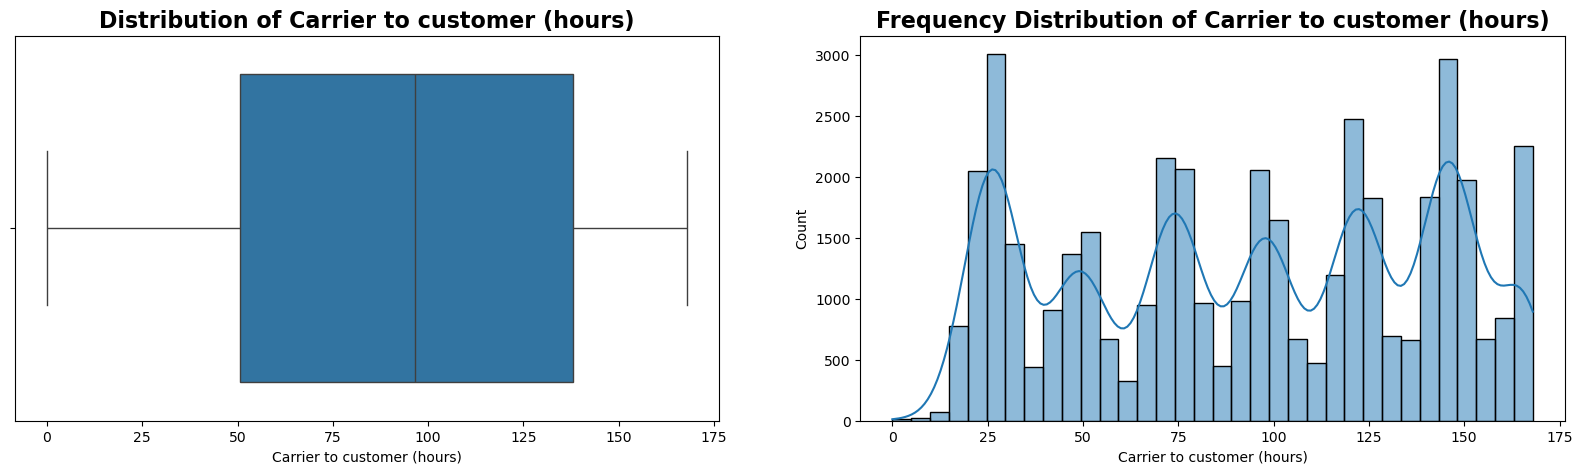

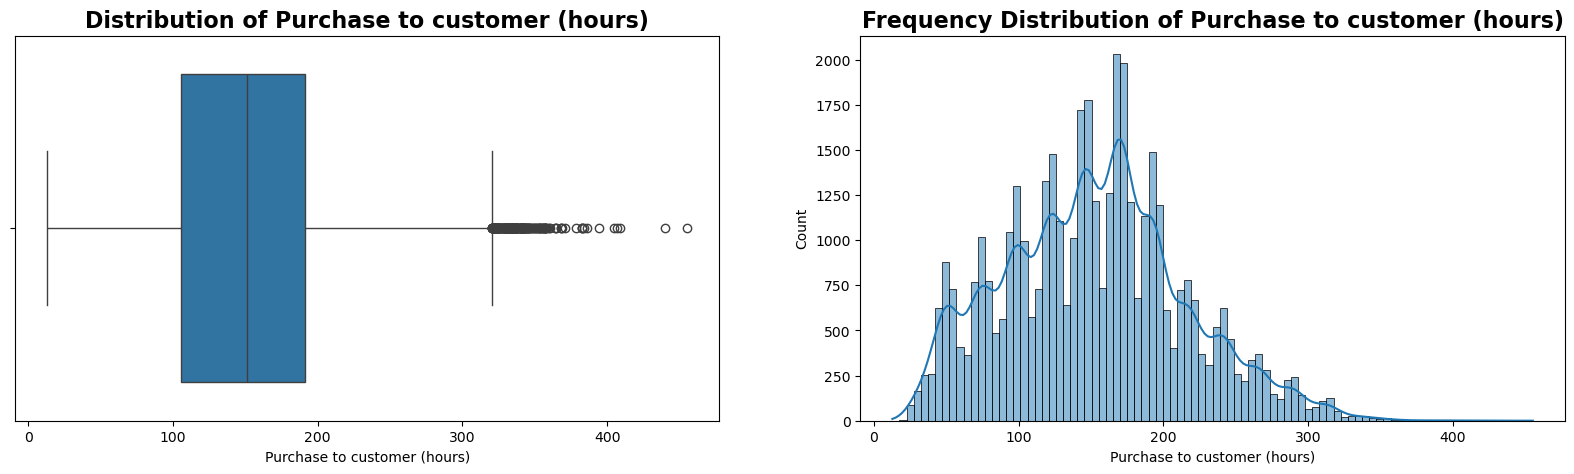

In [107]:
# show final distribution
for dc in durations_cols:
  showDistributionCombo(orders_df.assign(temp=orders_df[dc] / 3600), 'temp', dc.replace('_', ' ', -1).capitalize() + ' (hours)')

### **Order Items Dataset**

**`olist_order_items_dataset.csv` (112,650 rows)**

| Column Name           | Data Type        | Description                                                |
| --------------------- | ---------------- | ---------------------------------------------------------- |
| `order_id`            | `object`/`string`         | Identifier linking to the order.                           |
| `order_item_id`       | `int64`          | Sequential number identifying items within the same order. |
| `product_id`          | `object`/`string`         | Identifier for the purchased product.                      |
| `seller_id`           | `object`/`string`         | Identifier for the seller of the product.                  |
| `shipping_limit_date` | `datetime64` | Latest date the seller should ship the item.               |
| `price`               | `float64`        | Price paid for the item.                                   |
| `freight_value`       | `float64`        | Shipping cost charged for the item.                        |


In [108]:
order_items_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


#### **Unique Values**

In [109]:
showUniqueValues(order_items_df, 6999)

,Column Name,Number of Unique,Unique Sample
6,freight_value,6999,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.2, 0.21, 0.25, 0.28, 0.29, 0.31, 0.32, 0.33, 0.34, 0.37, 0.4, 0.45, 0.47, 0.48, 0.53, 0.56, 0.58, 0.61, 0.62, 0.63, 0.65, 0.69, 0.75, 0.76, 0.78, 0.8, 0.82, 0.83, 0.86, 0.88, 0.91, 0.92, 0.96, 0.97, 0.98, 0.99, 1.0, 1.01, 1.04, 1.05, 1.06, 1.08, 1.09, 1.1, 1.12, 1.14, 1.15, 1.18, 1.2, 1.22, 1.24, 1.26, 1.27, 1.28, 1.3, 1.32, 1.33, 1.34, 1.36, 1.37, 1.38, 1.39, 1.4, 1.41, 1.43, 1.44, 1.45, 1.46, 1.48, 1.51, 1.52, 1.55, 1.57, 1.58, 1.61, 1.64, 1.66, 1.67, 1.68, 1.69, 1.7, 1.71, 1.72, 1.73, ...]"
5,price,5968,"[0.85, 1.2, 2.2, 2.29, 2.9, 2.99, 3.0, 3.06, 3.49, 3.5, 3.54, 3.85, 3.9, 3.98, 3.99, 4.2, 4.3, 4.4, 4.5, 4.78, 4.85, 4.9, 4.99, 5.0, 5.18, 5.2, 5.3, 5.31, 5.35, 5.4, 5.49, 5.5, 5.53, 5.6, 5.7, 5.73, 5.85, 5.9, 5.95, 5.99, 6.0, 6.04, 6.1, 6.12, 6.15, 6.19, 6.25, 6.27, 6.3, 6.33, 6.35, 6.37, 6.49, 6.5, 6.57, 6.8, 6.84, 6.9, 6.99, 7.0, 7.09, 7.12, 7.18, 7.29, 7.3, 7.45, 7.48, 7.49, 7.5, 7.59, 7.6, 7.63, 7.65, 7.68, 7.78, 7.79, 7.8, 7.84, 7.87, 7.9, 7.96, 7.99, 8.0, 8.03, 8.09, 8.1, 8.2, 8.25, 8.33, 8.43, 8.45, 8.49, 8.5, 8.59, 8.6, 8.65, 8.68, 8.7, 8.73, 8.76, ...]"
3,seller_id,3095,"[0015a82c2db000af6aaaf3ae2ecb0532, 001cca7ae9ae17fb1caed9dfb1094831, 001e6ad469a905060d959994f1b41e4f, 002100f778ceb8431b7a1020ff7ab48f, 003554e2dce176b5555353e4f3555ac8, 004c9cd9d87a3c30c522c48c4fc07416, 00720abe85ba0859807595bbf045a33b, 00ab3eff1b5192e5f1a63bcecfee11c8, 00d8b143d12632bad99c0ad66ad52825, 00ee68308b45bc5e2660cd833c3f81cc, 00fc707aaaad2d31347cf883cd2dfe10, 010543a62bd80aa422851e79a3bc7540, 010da0602d7774602cd1b3f5fb7b709e, 011b0eaba87386a2ae96a7d32bb531d1, 01266d4c46afa519678d16a8b683d325, 013900e863eace745d3ec7614cab5b1a, 014c0679dd340a0e338872e7ec85666a, 014d9a685fd57276679edd00e07089e5, 0176f73cc1195f367f7b32db1e5b3aa8, 01bcc9d254a0143f0ce9791b960b2a47, 01c97ebb5cdac52891c0ed1c37ba0012, 01cf7e3d21494c41fb86034f2e714fa1, 01ed254b9ff8407dfb9d99ba1e17d923, 01fd077212124329bac32490e8ef80d9, 01fdefa7697d26ad920e9e0346d4bd1b, 0241d4d5d36f10f80c644447315af0bd, 0249d282d911d23cb8b869ab49c99f53, 024b564ae893ce8e9bfa02c10a401ece, 028872bfa080090a9d0abd4f1af168f8, 02a2272692e13558373c66db98f05e2e, 02b72cdeb9cfcc429f1af6f4e3f3b737, 02c988090b766852e088c69d7fb3b551, 02d35243ea2e497335cd0f076b45675d, 02dcd3e8e25bee036e32512bcf175493, 02ecc2a19303f05e59ce133fd923fff7, 02f5837340d7eb4f653d676c7256523a, 02f623a8eb246f3c5f7c2f96462654e6, 0307f7565ff85b299b6e5ef162b1b1a9, 0336182e1b3e92f029d5354832045fdf, 034b9387752bfa309f350a70cd45ffa3, 038b75b729c8a9a04b0d07cba7eabe86, 039b29ff3b3473435d0cd59040575de9, 039e6ad9dae79614493083e241147386, 03a2a6dcbe45d639c4dc2a0d24769c40, 03bd479e1d9484cdb14104d3023f7321, 0417b067eeab773d2f7061a726dc477f, 042573af89b6d931f672efaf789d8358, 04308b1ee57b6625f47df1d56f00eedf, 0432ead42b6c8a0bdf68154add917fdf, 044668ccd5316b12a7cf0d54a156e3e9, 04843805947f0fc584fc1969b6e50fe7, 048c2757535328e0d7dac690ad3c0aae, 04aa0a1c5ce6b222003403a3e11c3cc0, 04aba03279157f6d4e0fe8ccaf21963c, 04e38a233f726ef161074ab1c9b0399a, 04ee0ec01589969663ba5967c0e0bdc0, 04fdea0c111866e6cf812f1570d6b5bd, 0509040ea3fe50071181bbc359eb7738, 052577151711aec5c744fe12e66db3e1, 054694fa03fe82cec4b7551487331d74, 056b4ada5bbc2c50cc7842547dda6b51, 0570350b23eda5444f8d1d9544932058, 05730013efda596306417c3b09302475, 058cb5aeb36d7c0fcae20fc85d5e0a59, 058fd0aa2bfdb2274e05e1ae971dabb6, 05a48cc8859962767935ab9087417fbb, 05a940b4ecae36cadfd8e93bd9c43257, 05aebce0b5c8f0d41b29b686f2d05fd3, 05ca864204d09595ae591b93ea9cf93d, 05d2173d43ea568aa0540eba70d2ca76, 05e107217c7266362fd44b75b2cd4cc4, 05f51e13da97139648b8125c31e5f51b, 05feb94f19d094d4b0f9281f0b1d4c99, 05ff92fedb5be47920fea08e501238b9, 062c325cd6a2b87845fab56b4ec2eeae, 062ce95fa2ad4dfaedfc79260130565f, 06532f10282704ef4c69168b914b77be, 06579cb253ecd5a3a12a9e6eb6bf8f47, 066a6914e1ebf3ea95a216c73a986b91, 0691148aee60ca47977c187804f935ae, 0692610d8abe24f

#### **Handle Column Type**

In [110]:
# Change 'shipping_limit_date' into datetime
order_items_df['shipping_limit_date'] = pd.to_datetime(order_items_df['shipping_limit_date'])

#### **Missing Values**

In [111]:
order_items_df.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

No missing values, no action needed.

#### **Duplicates**

In [112]:
order_items_df.duplicated().sum()

0

No duplicates found, no action needed.

#### **Feature Engineering**

In [113]:
order_items_df['shipping_limit_date_year'] = order_items_df['shipping_limit_date'].dt.year
order_items_df['shipping_limit_date_month'] = order_items_df['shipping_limit_date'].dt.month
order_items_df['shipping_limit_date_day'] = order_items_df['shipping_limit_date'].dt.day
order_items_df['shipping_limit_date_hour'] = order_items_df['shipping_limit_date'].dt.hour
order_items_df['shipping_limit_date_minute'] = order_items_df['shipping_limit_date'].dt.minute
order_items_df['shipping_limit_date_second'] = order_items_df['shipping_limit_date'].dt.second

#### **Unrealistic Values/Outliers**

In [114]:
# check date - year values
order_items_df['shipping_limit_date_year'].value_counts()

shipping_limit_date_year
2018    62511
2017    49765
2016      370
2020        4
Name: count, dtype: int64

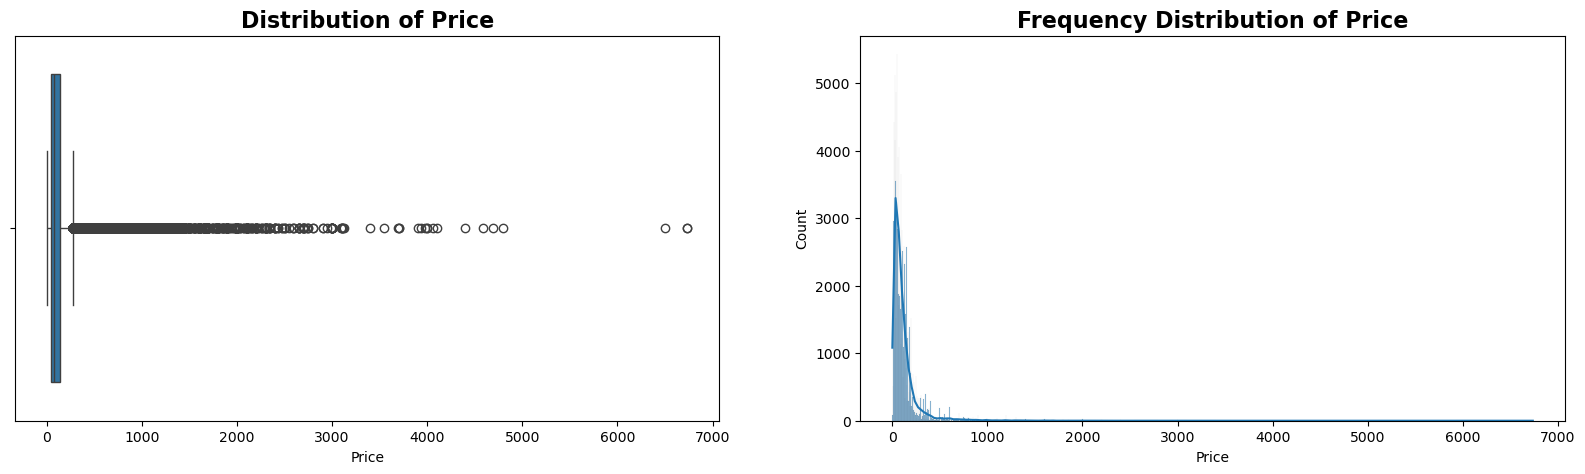

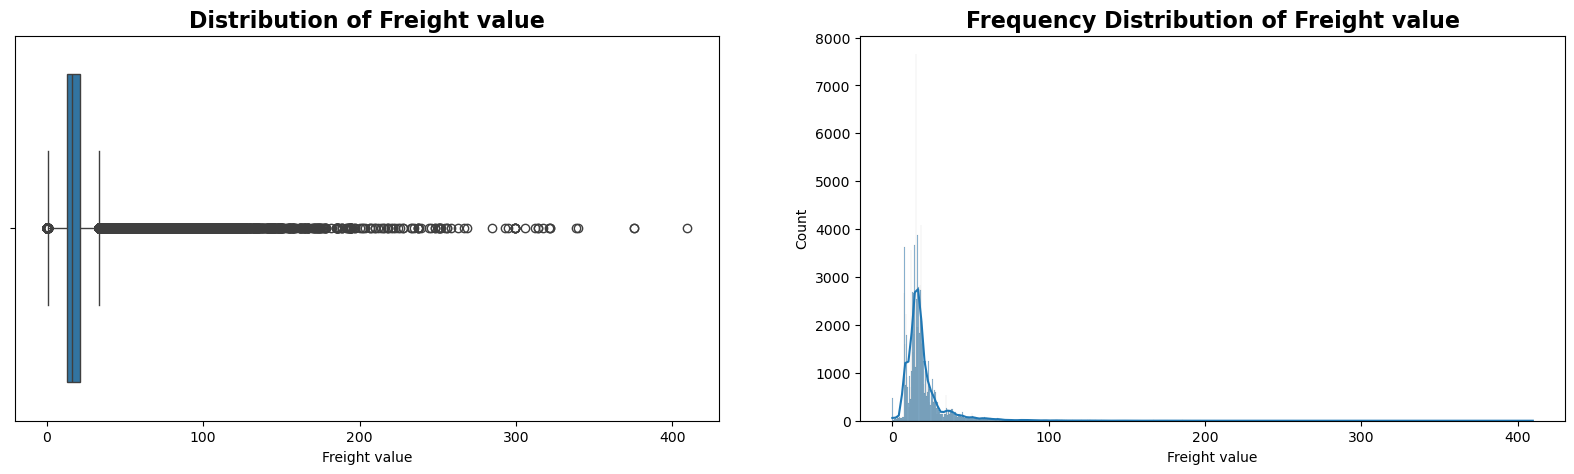

In [115]:
# check price & freight value distribution
order_items_float_cols = ['price', 'freight_value']

for oifc in order_items_float_cols:
  showDistributionCombo(order_items_df, oifc, oifc.replace('_', ' ', -1).capitalize())

Most of the items purchased are valued pretty similarly. However we can see that the distribution is skewed heavily to the right. We can also see some outliers for both `price` and `freight_value`. We will be removing extreme outliers.

In [116]:
order_items_df= order_items_df[order_items_df['price'] <= 5000]
order_items_df= order_items_df[order_items_df['freight_value'] <= 350]

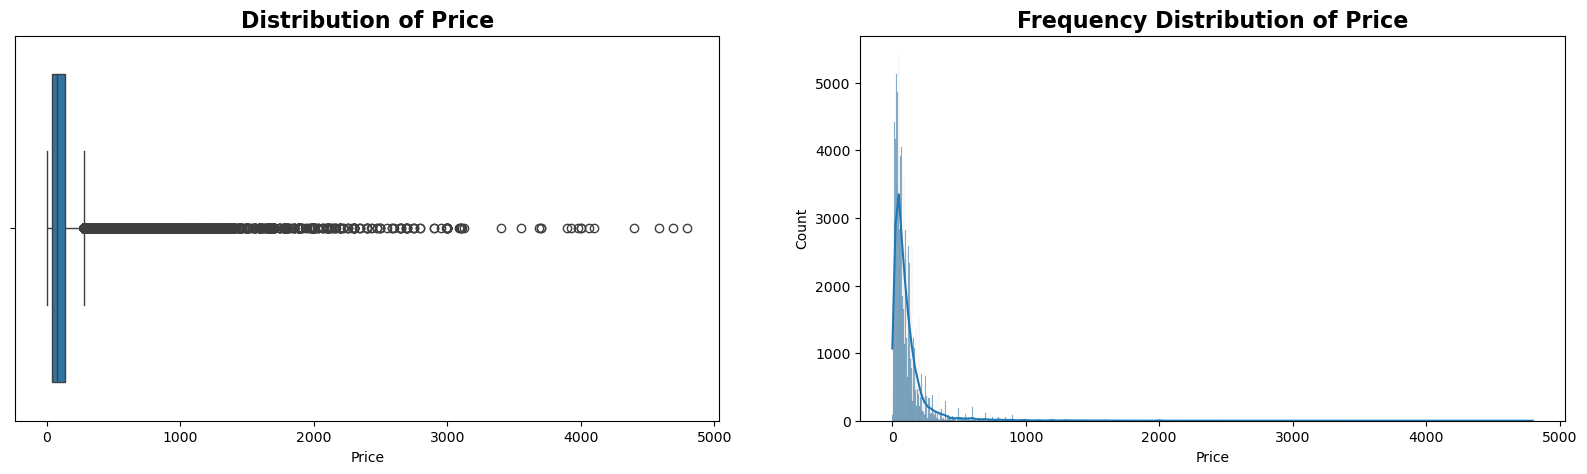

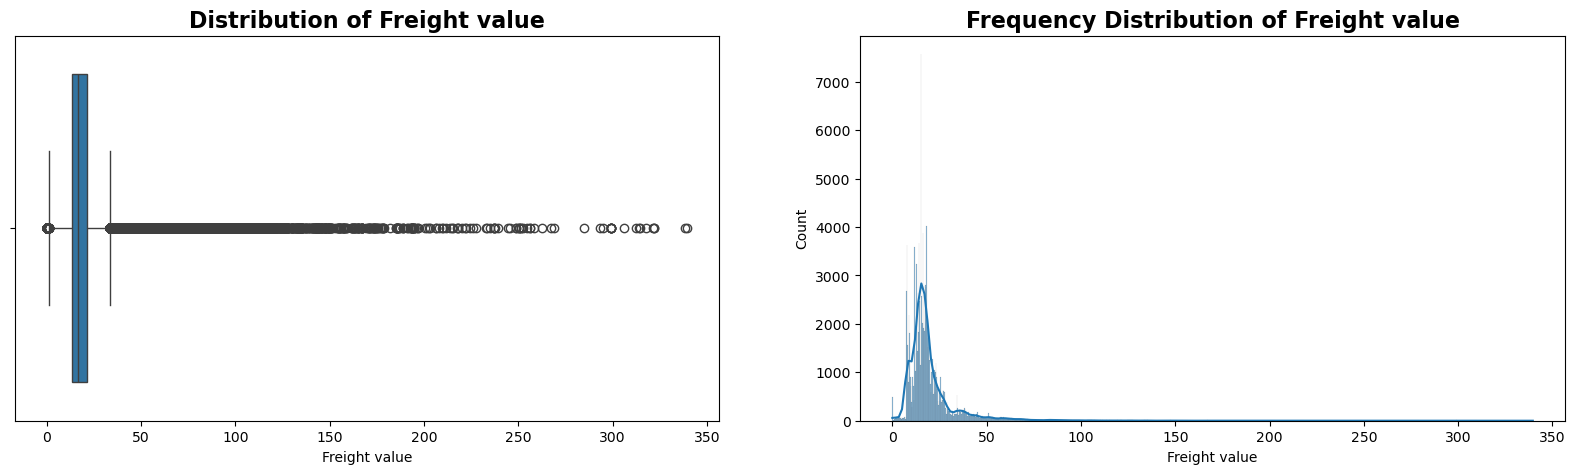

In [117]:
for oifc in order_items_float_cols:
  showDistributionCombo(order_items_df, oifc, oifc.replace('_', ' ', -1).capitalize())

### **Order Payments**

**`olist_order_payments_dataset.csv` (103,886 rows)**

| Column Name            | Data Type | Description                                                         |
| ---------------------- | --------- | ------------------------------------------------------------------- |
| `order_id`             | `object`/`string`  | Identifier linking to the order.                                    |
| `payment_sequential`   | `int64`   | Sequential number identifying multiple payments for the same order. |
| `payment_type`         | `object`/`string`  | Payment method used (e.g., credit card, boleto).                    |
| `payment_installments` | `int64`   | Number of installments for the payment.                             |
| `payment_value`        | `float64` | Total amount paid in the transaction.                               |

In [118]:
order_payments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


#### **Unique Values**

In [119]:
showUniqueValues(order_payments_df, 29077)

,Column Name,Number of Unique,Unique Sample
4,payment_value,29077,"[0.0, 0.01, 0.03, 0.05, 0.07, 0.08, 0.09, 0.1, 0.11, 0.13, 0.14, 0.15, 0.16, 0.17, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.31, 0.32, 0.33, 0.34, 0.36, 0.37, 0.38, 0.39, 0.41, 0.42, 0.43, 0.44, 0.47, 0.48, 0.49, 0.52, 0.53, 0.54, 0.55, 0.56, 0.58, 0.59, 0.6, 0.61, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.72, 0.73, 0.74, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.91, 0.92, 0.93, 0.94, 0.96, 0.97, 0.98, 0.99, 1.0, 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1, 1.11, 1.12, 1.14, 1.15, 1.16, 1.17, 1.18, 1.2, 1.21, 1.22, 1.23, ...]"
1,payment_sequential,29,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]"
3,payment_installments,24,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24]"
2,payment_type,5,"[boleto, credit_card, debit_card, not_defined, voucher]"


#### **Handle Column Type**

In [120]:
# Change 'shipping_limit_date' into datetime
order_items_df['shipping_limit_date'] = pd.to_datetime(order_items_df['shipping_limit_date'])

#### **Missing Values**

In [121]:
order_payments_df.isna().sum()

order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

#### **Duplicates**

In [122]:
order_payments_df.duplicated().sum()

0

#### **Unrealistic Values/Outliers**

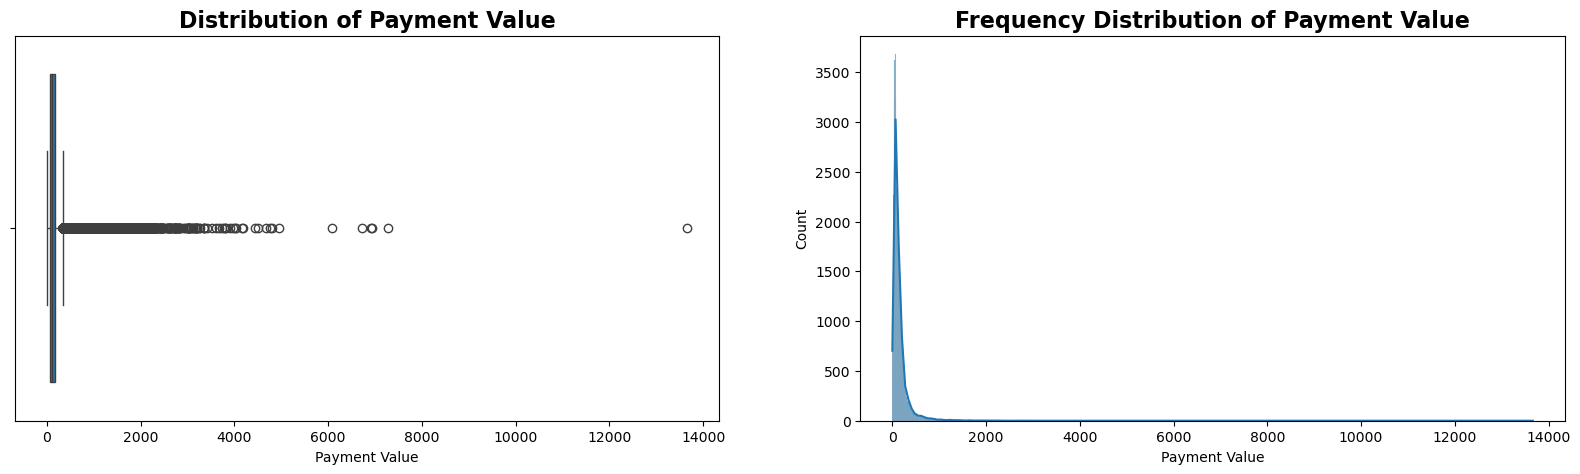

In [123]:
showDistributionCombo(order_payments_df, 'payment_value', 'Payment Value')

The visualization of `payment_value` shows a strong right skew, where most transactions fall below 1,000, while a small number of extreme values reach up to nearly 14,000. The box plot confirms a dense cluster of lower values with many outliers extending far beyond the upper whisker, indicating significant variability among a few high-value orders. Though it might be important, we will remove all data above **6000**.

In [124]:
order_payments_df = order_payments_df[order_payments_df['payment_value'] <= 6000]

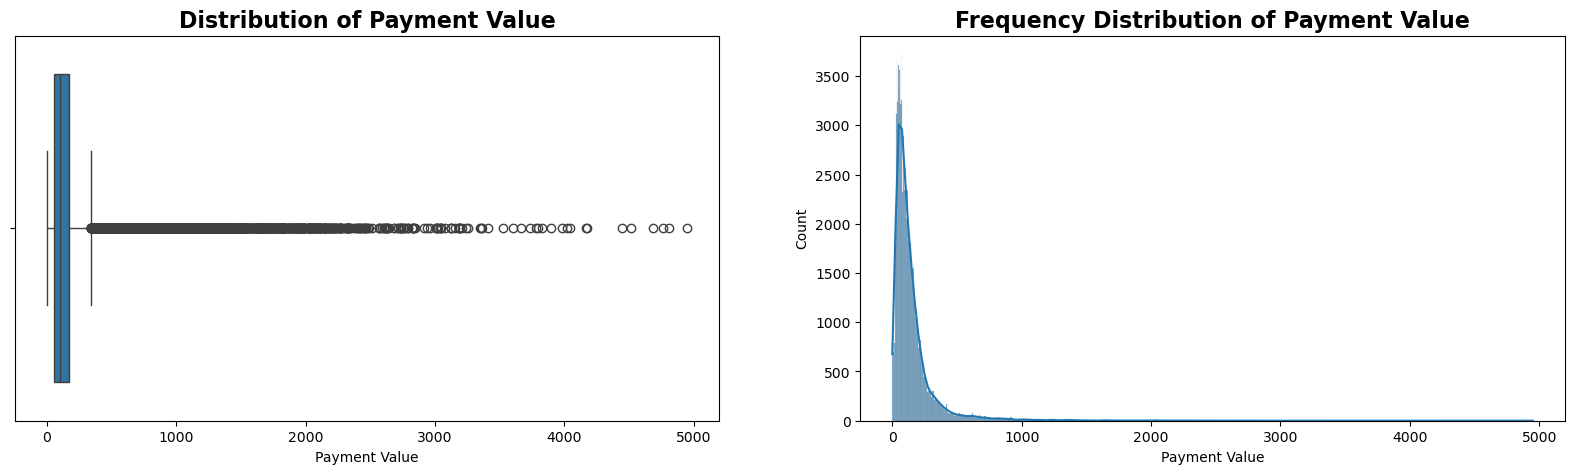

In [125]:
showDistributionCombo(order_payments_df, 'payment_value', 'Payment Value')

In [126]:
# check payment type count
order_payments_df['payment_type'].value_counts()

payment_type
credit_card    76793
boleto         19780
voucher         5775
debit_card      1529
not_defined        3
Name: count, dtype: int64

The `payment_type` distribution is dominated by credit card transactions, followed by boleto, voucher, and debit card payments. All categories appear valid and interpretable, except for the `not_defined` type, which lacks meaningful context or frequency to support analysis. Therefore, we will remove entries with `not_defined` as their payment type to maintain data quality and ensure consistency in further analysis.

### **Order Reviews Dataset**

**`olist_order_reviews_dataset.csv` (100,000 rows)**

| Column Name               | Data Type        | Description                                           |
| ------------------------- | ---------------- | ----------------------------------------------------- |
| `review_id`               | `object`/`string`         | Unique identifier for each review.                    |
| `order_id`                | `object`/`string`         | Identifier linking to the order.                      |
| `review_score`            | `int64`          | Score given by the customer (1 to 5).                 |
| `review_comment_title`    | `object`/`string`         | Title of the review comment.                          |
| `review_comment_message`  | `object`/`string`         | Content of the review comment.                        |
| `review_creation_date`    | `object`/`string` | Date when the review was created.                     |
| `review_answer_timestamp` | `object`/`string` | Timestamp when the review was answered by the seller. |

In [127]:
order_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


#### **Unique Values**

In [128]:
showUniqueValues(order_reviews_df, 36159)

Column Name  Number of Unique  \
4  review_comment_message             36159   
3    review_comment_title              4527   
5    review_creation_date               636   
2            review_score                 5   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

#### **Handle Column Types**

In [129]:
# Change 'review_creation_date' & 'review_answer_timestamp' into datetime
order_reviews_df['review_creation_date'] = pd.to_datetime(order_reviews_df['review_creation_date'])
order_reviews_df['review_answer_timestamp'] = pd.to_datetime(order_reviews_df['review_answer_timestamp'])

#### **Missing Values**

In [130]:
order_reviews_df.isna().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

We can see that there are loads of missing values in the title & message sections, which is expected. To handle this we will be changing these values to an empty string.

In [131]:
order_reviews_df['review_comment_title'] = order_reviews_df['review_comment_title'].fillna("")
order_reviews_df['review_comment_message'] = order_reviews_df['review_comment_message'].fillna("")

#### **Duplicates**

In [132]:
order_reviews_df.duplicated().sum()

0

#### **Feature Engineering**

In [133]:
review_dt_cols = ['review_creation_date', 'review_answer_timestamp']

for rdc in review_dt_cols:
	order_reviews_df[f'{rdc}_year'] = order_reviews_df[rdc].dt.year
	order_reviews_df[f'{rdc}_month'] = order_reviews_df[rdc].dt.month
	order_reviews_df[f'{rdc}_day'] = order_reviews_df[rdc].dt.day
	order_reviews_df[f'{rdc}_hour'] = order_reviews_df[rdc].dt.hour
	order_reviews_df[f'{rdc}_minute'] = order_reviews_df[rdc].dt.minute
	order_reviews_df[f'{rdc}_second'] = order_reviews_df[rdc].dt.second

#### **Unrealistic Values/Outliers**

In [134]:
# check for unique timestamp data
for rdc in review_dt_cols:
  print(order_reviews_df[f'{rdc}_year'].value_counts(), '\n')

review_creation_date_year
2018    56164
2017    42735
2016      325
Name: count, dtype: int64 

review_answer_timestamp_year
2018    56843
2017    42070
2016      311
Name: count, dtype: int64 



In [135]:
for rdc in review_dt_cols:
  print(order_reviews_df[f'{rdc}_hour'].value_counts(), '\n')

review_creation_date_hour
0    99139
1       85
Name: count, dtype: int64 

review_answer_timestamp_hour
23    6982
11    6938
0     6487
12    6411
21    5885
22    5795
1     5718
13    5370
19    5081
20    5071
10    4987
14    4926
18    4357
15    4327
17    4235
16    4212
2     3778
9     2679
3     2320
4     1136
8     1062
5      576
7      467
6      424
Name: count, dtype: int64 



### **Products Dataset**

**`olist_products_dataset.csv` (32,951 rows)**

| Column Name                  | Data Type | Description                                   |
| ---------------------------- | --------- | --------------------------------------------- |
| `product_id`                 | `object`/`string`  | Unique identifier for each product.           |
| `product_category_name`      | `object`/`string`  | Category of the product (in Portuguese).      |
| `product_name_lenght`        | `float64` | Length of the product name.                   |
| `product_description_lenght` | `float64` | Length of the product description.            |
| `product_photos_qty`         | `float64` | Number of photos associated with the product. |
| `product_weight_g`           | `float64` | Weight of the product in grams.               |
| `product_length_cm`          | `float64` | Length of the product package in centimeters. |
| `product_height_cm`          | `float64` | Height of the product package in centimeters. |
| `product_width_cm`           | `float64` | Width of the product package in centimeters.  |

In [136]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


#### **Unique Values**

In [137]:
showUniqueValues(products_df, 2960)

,Column Name,Number of Unique,Unique Sample
3,product_description_lenght,2960,"[4.0, 8.0, 15.0, 20.0, 23.0, 26.0, 27.0, 28.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, ...]"
5,product_weight_g,2204,"[0.0, 2.0, 25.0, 50.0, 53.0, 54.0, 55.0, 58.0, 60.0, 61.0, 63.0, 65.0, 67.0, 70.0, 75.0, 76.0, 77.0, 78.0, 80.0, 82.0, 83.0, 85.0, 87.0, 88.0, 90.0, 91.0, 92.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 102.0, 103.0, 104.0, 105.0, 107.0, 108.0, 110.0, 111.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 132.0, 133.0, 135.0, 136.0, 137.0, 138.0, 139.0, 140.0, 143.0, 144.0, 145.0, 146.0, 147.0, 148.0, 150.0, 151.0, 152.0, 153.0, 154.0, 155.0, 156.0, 157.0, 158.0, 160.0, 161.0, 162.0, 163.0, 165.0, 166.0, 167.0, 169.0, 170.0, 171.0, 172.0, 173.0, 175.0, 177.0, 178.0, 179.0, 180.0, ...]"
7,product_height_cm,102,"[2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 102.0, 103.0, ...]"
6,product_length_cm,99,"[7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, nan]"
8,product_width_cm,95,"[6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 90.0, 91.0, 92.0, 93.0, 95.0, 97.0, 98.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 118.0, nan]"
1,product_category_name,73,"[agro_industria_e_comercio, alimentos, alimentos_bebidas, artes, artes_e_artesanato, artigos_de_festas, artigos_de_natal, audio, automotivo, bebes, bebidas, beleza_saude, brinquedos, cama_mesa_banho, casa_conforto, casa_conforto_2, casa_construcao, cds_dvds_musicais, cine_foto, climatizacao, consoles_games, construcao_ferramentas_construcao, construcao_ferramentas_ferramentas, construcao_ferramentas_iluminacao, construcao_ferramentas_jardim, construcao_ferramentas_seguranca, cool_stuff, dvds_blu_ray, eletrodomesticos, eletrodomesticos_2, eletronicos, eletroportateis, esporte_lazer, fashion_bolsas_e_acessorios, fashion_calcados, fashion_esporte, fashion_roupa_feminina, fashion_roupa_infanto_juvenil, fa

#### **Missing Values**

In [138]:
products_df.isnull().sum()

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

Most of the values missing are floats, so we can change that to 0 or an empty string

In [139]:
products_df['product_name_lenght'] = products_df['product_name_lenght'].fillna(0)
products_df['product_description_lenght'] = products_df['product_description_lenght'].fillna(0)
products_df['product_photos_qty'] = products_df['product_photos_qty'].fillna(0)
products_df['product_category_name'] = products_df['product_category_name'].fillna("")

#### **Handle Column Types**

In [140]:
products_df['product_name_lenght'] = products_df['product_name_lenght'].astype(int)
products_df['product_description_lenght'] = products_df['product_description_lenght'].astype(int)
products_df['product_photos_qty'] = products_df['product_photos_qty'].astype(int)

Change floats into int.

#### **Duplicates**

In [141]:
products_df.duplicated().sum()

0

#### **Feature Engineering**

In [142]:
products_df['product_volume_cm3'] =  products_df['product_length_cm'] * products_df['product_height_cm'] * products_df['product_width_cm']

Add product volume calculation

#### **Unrealistic Values/Outliers**

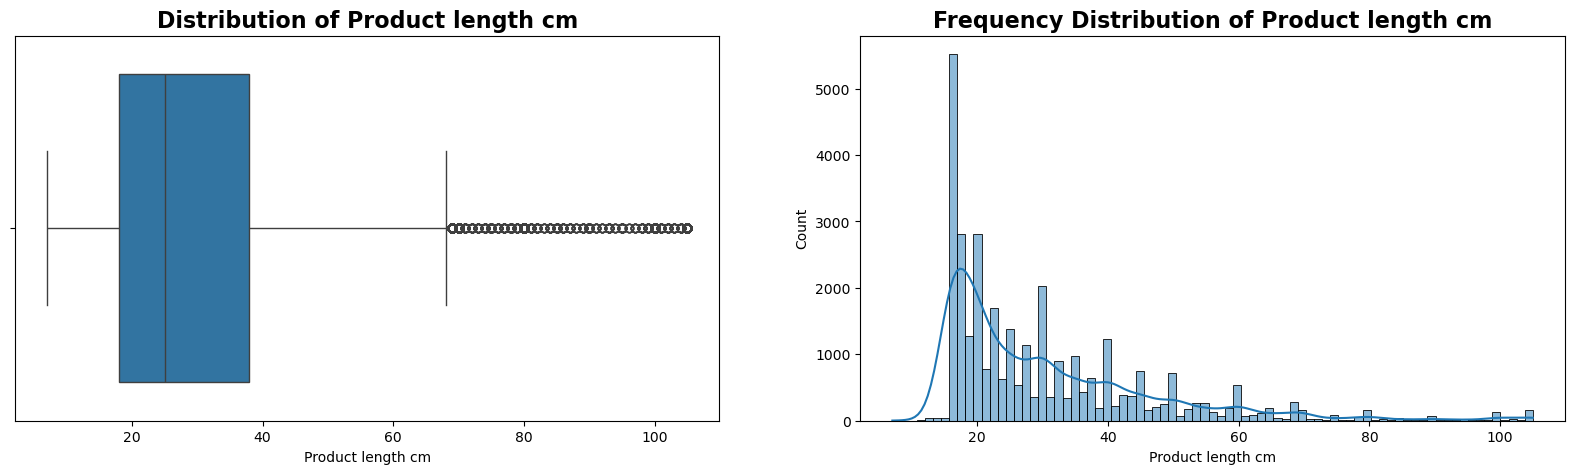

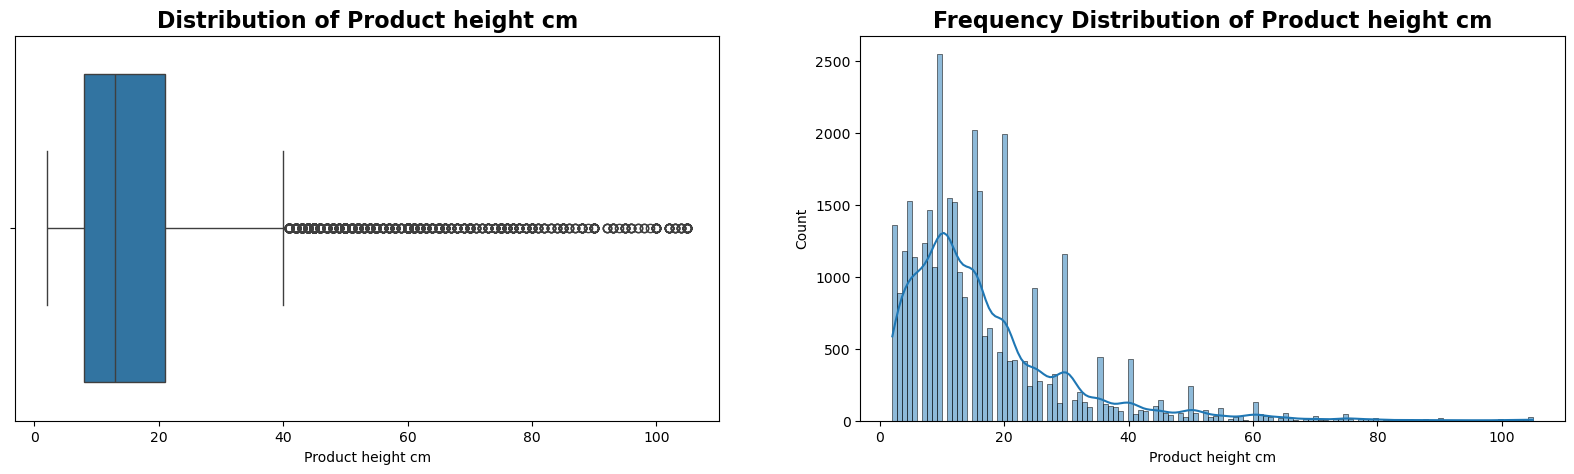

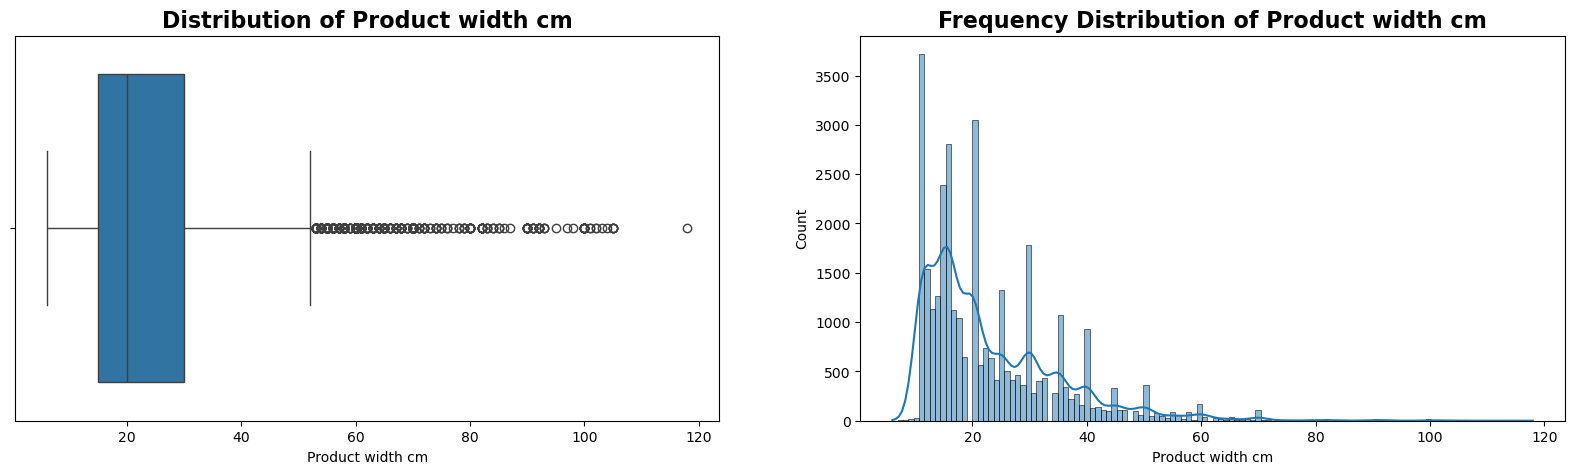

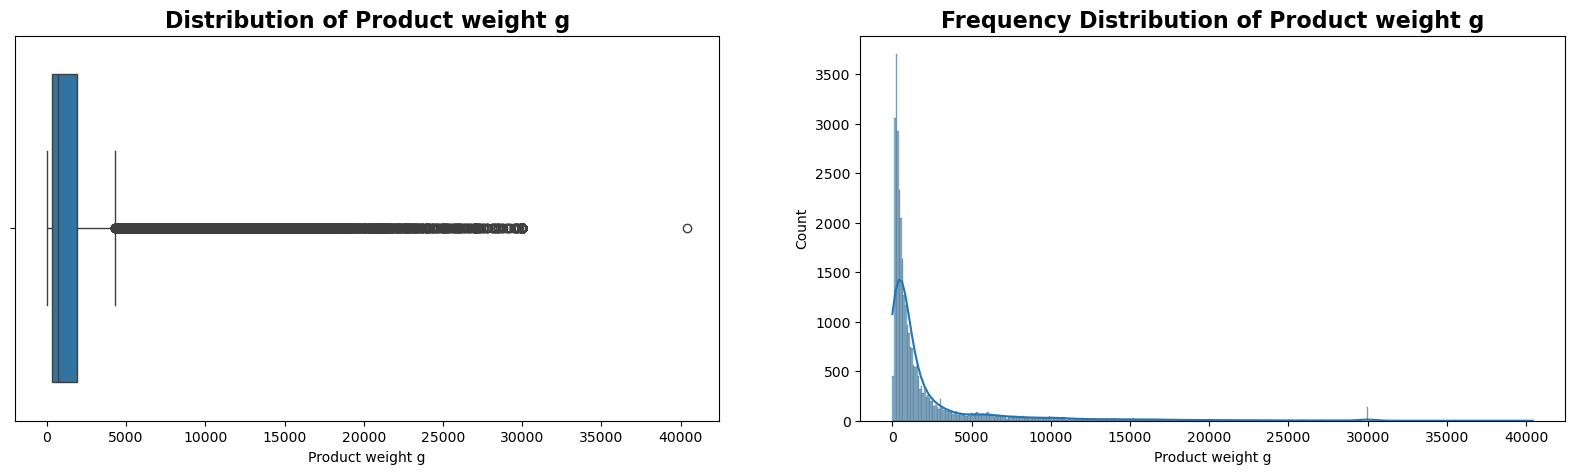

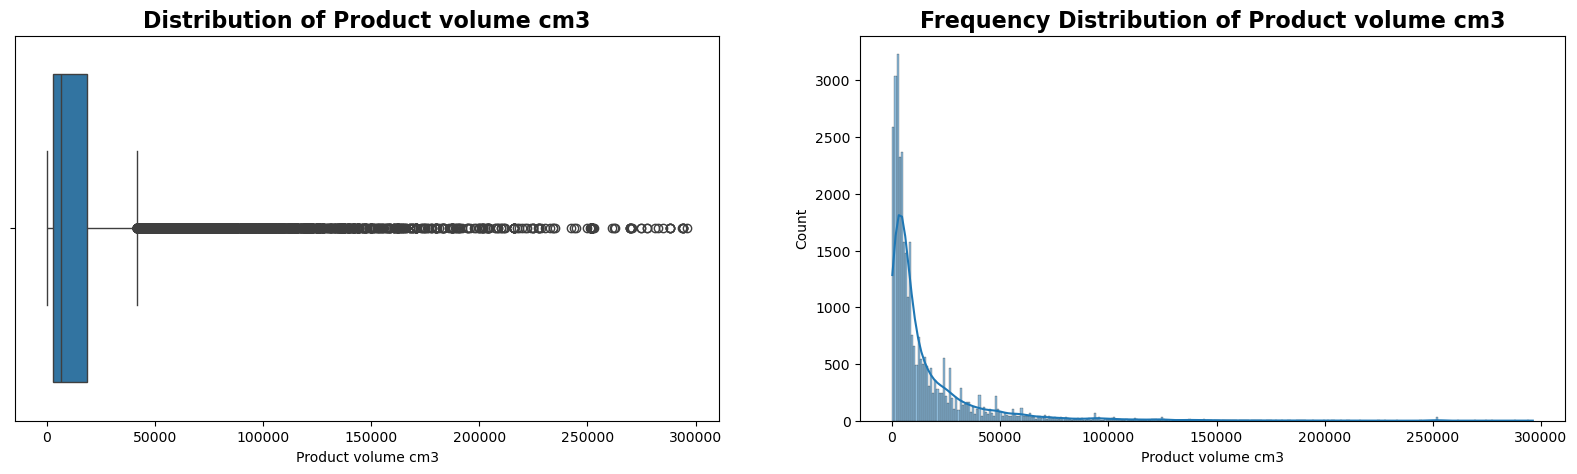

In [143]:
# check price & freight value distribution
products_float_cols = ['product_length_cm', 'product_height_cm', 'product_width_cm', 'product_weight_g', 'product_volume_cm3']

for oifc in products_float_cols:
  showDistributionCombo(products_df, oifc, oifc.replace('_', ' ', -1).capitalize())

Based on the charts we can see there are 2 distinct outliers on `product_weight_g` and `product_width_cm`. We can also see that the distribution of `volume` and `weight` is rather similar, which aligns logically. Let's take a look if the 2 outliers are the same row.

In [144]:
products_df[(products_df['product_weight_g']>35000) | (products_df['product_width_cm']>112)]

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_volume_cm3
25166,26644690fde745fc4654719c3904e1db,cama_mesa_banho,59,534,1,40425.0,13.0,65.0,28.0,23660.0
26970,b17808303e15dd50538c011b44295427,cama_mesa_banho,56,502,3,1050.0,23.0,93.0,118.0,252402.0


It appears that those are 2 different items. The products' data also does not look logical / realistic, according to their weights and volume. We will remove them.

In [145]:
products_df['product_weight_g'] = products_df['product_weight_g']<35000
products_df['product_width_cm'] = products_df['product_width_cm']<112

### **Sellers Dataset**


**`olist_sellers_dataset.csv` (3,095 rows)**

| Column Name              | Data Type | Description                                 |
| ------------------------ | --------- | ------------------------------------------- |
| `seller_id`              | `object`/`string`  | Unique identifier for each seller.          |
| `seller_zip_code_prefix` | `int64`   | First five digits of the seller's zip code. |
| `seller_city`            | `object`/`string`  | City where the seller is located.           |
| `seller_state`           | `object`/`string`  | State where the seller is located.          |

In [146]:
sellers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


#### **Unique Values**

In [147]:
showUniqueValues(sellers_df, 2246)

,Column Name,Number of Unique,Unique Sample
1,seller_zip_code_prefix,2246,"[1001, 1021, 1022, 1023, 1026, 1031, 1035, 1039, 1040, 1041, 1042, 1044, 1123, 1125, 1126, 1127, 1129, 1131, 1139, 1140, 1156, 1201, 1206, 1207, 1208, 1209, 1210, 1212, 1214, 1215, 1220, 1222, 1223, 1224, 1226, 1230, 1233, 1238, 1239, 1244, 1254, 1257, 1303, 1309, 1310, 1311, 1314, 1319, 1320, 1403, 1408, 1411, 1417, 1420, 1421, 1425, 1452, 1511, 1512, 1529, 1530, 1539, 1541, 1545, 1547, 1550, 1552, 2013, 2016, 2022, 2028, 2030, 2034, 2035, 2036, 2040, 2047, 2050, 2051, 2066, 2110, 2112, 2113, 2116, 2117, 2118, 2119, 2122, 2124, 2134, 2150, 2189, 2215, 2220, 2236, 2238, 2242, 2252, 2258, 2261, ...]"
2,seller_city,611,"[04482255, abadia de goias, afonso claudio, aguas claras df, alambari, alfenas, almirante tamandare, alvares machado, alvorada, americana, amparo, ampere, anapolis, andira-pr, andradas, angra dos reis, angra dos reis rj, ao bernardo do campo, aparecida, aparecida de goiania, aperibe, apucarana, aracaju, aracatuba, araguari, arapongas, araquari, ararangua, araraquara, araras, araucaria, araxa, arinos, armacao dos buzios, arraial d'ajuda (porto seguro), artur nogueira, aruja, arvorezinha, assis, atibaia, auriflama, auriflama/sp, avare, bady bassitt, baependi, bage, bahia, balenario camboriu, balneario camboriu, bandeirantes, barbacena, barbacena/ minas gerais, bariri, barra mansa, barra velha, barretos, barrinha, barro alto, barueri, batatais, bauru, bebedouro, belford roxo, belo horizont, belo horizonte, bento goncalves, bertioga, betim, birigui, blumenau, bocaiuva do sul, bofete, boituva, bom jardim, bom jesus dos perdoes, bombinhas, bonfinopolis de minas, borda da mata, botucatu, braco do norte, braganca paulista, brasilia, brasilia df, brejao, brotas, brusque, buritama, cacador, cachoeira do sul, cachoeirinha, cachoeiro de itapemirim, cafelandia, caieiras, cajamar, california, camanducaia, cambe, camboriu, campanha, campina das missoes, ...]"
3,seller_state,23,"[AC, AM, BA, CE, DF, ES, GO, MA, MG, MS, MT, PA, PB, PE, PI, PR, RJ, RN, RO, RS, SC, SE, SP]"


#### **Missing Values**

In [148]:
sellers_df.isnull().sum()

seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

#### **Duplicates**

In [149]:
sellers_df.duplicated().sum()

0

### **Others**

**`olist_geolocation_dataset.csv` (1,000,016 rows)**

| Column Name                   | Data Type | Description                          |
| ----------------------------- | --------- | ------------------------------------ |
| `geolocation_zip_code_prefix` | `int64`   | First five digits of the zip code.   |
| `geolocation_lat`             | `float64` | Latitude coordinate.                 |
| `geolocation_lng`             | `float64` | Longitude coordinate.                |
| `geolocation_city`            | `object`/`string`  | City corresponding to the zip code.  |
| `geolocation_state`           | `object`/`string`  | State corresponding to the zip code. |

<br>

**`product_category_name_translation.csv` (71 rows)**

| Column Name                     | Data Type | Description                          |
| ------------------------------- | --------- | ------------------------------------ |
| `product_category_name`         | `object`/`string`  | Product category name in Portuguese. |
| `product_category_name_english` | `object`/`string`  | Product category name in English.    |

### **Consolidate Tables (Optional)**

In [150]:
# translate product categories
final_products_df = products_df.merge(pcateg_translation_df, on='product_category_name', how='inner')
final_products_df = final_products_df.drop(columns=['product_category_name'])
final_products_df = final_products_df.rename(columns={'product_category_name_english': 'product_category_name'})
final_products_df

,product_id,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_volume_cm3,product_category_name
0,1e9e8ef04dbcff4541ed26657ea517e5,40,287,1,True,16.0,10.0,True,2240.0,perfumery
1,3aa071139cb16b67ca9e5dea641aaa2f,44,276,1,True,30.0,18.0,True,10800.0,art
2,96bd76ec8810374ed1b65e291975717f,46,250,1,True,18.0,9.0,True,2430.0,sports_leisure
3,cef67bcfe19066a932b7673e239eb23d,27,261,1,True,26.0,4.0,True,2704.0,baby
4,9dc1a7de274444849c219cff195d0b71,37,402,4,True,20.0,17.0,True,4420.0,housewares
...,...,...,...,...,...,...,...,...,...,...
32323,a0b7d5a992ccda646f2d34e418fff5a0,45,67,2,True,40.0,40.0,True,64000.0,furniture_decor
32324,bf4538d88321d0fd4412a93c974510e6,41,971,1,True,16.0,19.0,True,4864.0,construction_tools_lights
32325,9a7c6041fa9592d9d9ef6cfe62a71f8c,50,799,1,True,27.0,7.0,True,5103.0,bed_bath_table
32326,83808703fc0706a22e264b9d75f04a2e,60,156,2,True,31.0,13.0,True,8060.0,computers_accessories


In [151]:
# order related data
final_order_df = orders_df.merge(order_items_df, on='order_id', how='inner')
final_order_df = final_order_df.merge(order_payments_df, on='order_id', how='inner')
# final_order_df = final_order_df.merge(order_reviews_df, on='order_id', how='inner')
final_order_df = final_order_df.merge(final_products_df, on='product_id', how='inner')
final_order_df

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_timestamp_year,order_purchase_timestamp_month,order_purchase_timestamp_day,order_purchase_timestamp_hour,order_purchase_timestamp_minute,order_purchase_timestamp_second,order_approved_at_year,order_approved_at_month,order_approved_at_day,order_approved_at_hour,order_approved_at_minute,order_approved_at_second,order_delivered_carrier_date_year,order_delivered_carrier_date_month,order_delivered_carrier_date_day,order_delivered_carrier_date_hour,order_delivered_carrier_date_minute,order_delivered_carrier_date_second,order_delivered_customer_date_year,order_delivered_customer_date_month,order_delivered_customer_date_day,order_delivered_customer_date_hour,order_delivered_customer_date_minute,order_delivered_customer_date_second,order_estimated_delivery_date_year,order_estimated_delivery_date_month,order_estimated_delivery_date_day,order_estimated_delivery_date_hour,order_estimated_delivery_date_minute,order_estimated_delivery_date_second,purchase_to_approval,approval_to_carrier,carrier_to_customer,purchase_to_customer,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,shipping_limit_date_year,shipping_limit_date_month,shipping_limit_date_day,shipping_limit_date_hour,shipping_limit_date_minute,shipping_limit_date_second,payment_sequential,payment_type,payment_installments,payment_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_volume_cm3,product_category_name
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017,10,2,10,56,33,2017.0,10.0,2.0,11.0,7.0,15.0,2017.0,10.0,4.0,19.0,55.0,0.0,2017.0,10.0,10.0,21.0,25.0,13.0,2017,10,18,0,0,0,642.0,204465.0,523813.0,728920.0,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,2017,10,6,11,7,15,1,credit_card,1,18.12,40,268,4,True,19.0,8.0,True,1976.0,housewares
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017,10,2,10,56,33,2017.0,10.0,2.0,11.0,7.0,15.0,2017.0,10.0,4.0,19.0,55.0,0.0,2017.0,10.0,10.0,21.0,25.0,13.0,2017,10,18,0,0,0,642.0,204465.0,523813.0,728920.0,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,2017,10,6,11,7,15,3,voucher,1,2.00,40,268,4,True,19.0,8.0,True,1976.0,housewares
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017,10,2,10,56,33,2017.0,10.0,2.0,11.0,7.0,15.0,2017.0,10.0,4.0,19.0,55.0,0.0,2017.0,10.0,10.0,21.0,25.0,13.0,2017,10,18,0,0,0,642.0,204465.0,523813.0,728920.0,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,2017,10,6,11,7,15,2,voucher,1,18.59,40,268,4,True,19.0,8.0,True,1976.0,housewares
3,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2018,2,13,21,18,39,2018.0,2.0,13.0,22.0,20.0,29.0,2018.0,2.0,14.0,19.0,46.0,34.0,2018.0,2.0,16.0,18.0,17.0,2.0,2018,2,26,0,0,0,3710.0,77165.0,167428.0,248303.0,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,2018,2,19,20,31,37,1,credit_card,1,28.62,38,316,4,True,51.0,15.0,True,11475.0,stationery
4,6514b8ad8028c9f2cc2374ded245783f,9bdf08b4b3b52b5526ff42d37d47f222,delivered,2017-05-16 13:10:30,2017-05-16 13:22:11,2017-05-22 10:07:46,2017-05-26 12:55:51,2017-06-07,2017,5,16,13,10,30,2017.0,5.0,16.0,13.0,22.0,11.0,2017.0,5.0,22.0,10.0,7.0,46.0,2017.0,5.0,26.

In [152]:
final_order_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50482 entries, 0 to 50481
Data columns (total 67 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   order_id                              50482 non-null  object        
 1   customer_id                           50482 non-null  object        
 2   order_status                          50482 non-null  object        
 3   order_purchase_timestamp              50482 non-null  datetime64[ns]
 4   order_approved_at                     50482 non-null  datetime64[ns]
 5   order_delivered_carrier_date          50482 non-null  datetime64[ns]
 6   order_delivered_customer_date         50482 non-null  datetime64[ns]
 7   order_estimated_delivery_date         50482 non-null  datetime64[ns]
 8   order_purchase_timestamp_year         50482 non-null  int32         
 9   order_purchase_timestamp_month        50482 non-null  int32         
 10

## **> Data Analysis**
<hr>

In [153]:
final_order_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50482 entries, 0 to 50481
Data columns (total 67 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   order_id                              50482 non-null  object        
 1   customer_id                           50482 non-null  object        
 2   order_status                          50482 non-null  object        
 3   order_purchase_timestamp              50482 non-null  datetime64[ns]
 4   order_approved_at                     50482 non-null  datetime64[ns]
 5   order_delivered_carrier_date          50482 non-null  datetime64[ns]
 6   order_delivered_customer_date         50482 non-null  datetime64[ns]
 7   order_estimated_delivery_date         50482 non-null  datetime64[ns]
 8   order_purchase_timestamp_year         50482 non-null  int32         
 9   order_purchase_timestamp_month        50482 non-null  int32         
 10